# Movies Recommendations

<a id="intro"></a>
<h3>   
    <font  color='Black'>
          <span>
               Dataset Information :
            </span>   
    </font>
</h3>

 
* __ID__:  Movie ID

* __Title__: Movie Title

* __Year__: Release Year

* __Age__: Age restriction

* __IMDB__: IMDB Rating

* __ROttern Tomatoes__: Tomatoes Rating

* __Netflix, Hulu,Prime Video, Disney+__: OTT Platforms

* __Type__: Movie Genres

* __DIrectors__: Movie Director

![](http://)* Country: Release in Country

## Task to be Performed:
- Import required libraries
- Read the dataset and perform necessary changes
- Generate a ProfileReport using Pandas Profiling
- Perform exploratory data analysis over the data
- Process the data for recommendation engine
- Create a recommendation engine using CountVectorizer
- Create a recommendation engine using KNN
- Create a WebApp using Streamlit which showcases both the engines and data analysis report

## Importing Libraries

In [ ]:
# Install the libraries if required
!pip install plotly  --quiet    --disable-pip-version-check
!pip install pandas_profiling  --quiet    --disable-pip-version-check
!pip install pycountry_convert  --quiet    --disable-pip-version-check

In [ ]:
import pandas as pd
import numpy as np
import pickle
import re
from pandas_profiling import ProfileReport
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from IPython.display import display
from ipywidgets import interactive, interact
import ipywidgets
from plotly.colors import hex_to_rgb
import pycountry_convert as pc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sklearn
import plotly 
import pandas_profiling

In [ ]:
# Make sure you are using the same verions for best performance
print('Pandas: ',pd.__version__)
print('Numpy: ',np.__version__)
print('Re: ',re.__version__)
print('IPYWidgets: ',ipywidgets.__version__)
print('Sklearn: ',sklearn.__version__)
print('Pycountry_convert: ',pc.__version__)
print('Plotly: ',plotly.__version__)
print('Pandas Profiling: ',pandas_profiling.__version__)

#### Make sure the above versions matches the below required ones:
- Pandas:  1.0.5
- Numpy:  1.19.0
- Re:  2.2.1
- IPYWidgets:  7.5.1
- Sklearn:  0.22.2.post1
- Pycountry_convert:  0.7.2
- Plotly:  4.9.0
- Pandas Profiling:  2.8.0

In [ ]:
#--use for extra imports


## Reading Dataset

In [ ]:
data = pd.read_csv('MoviesOnStreamingPlatforms_updated.csv')
data.head()

- There is one unnamed column. This can be easily removed.
- WE can set ID column as index then.

In [ ]:
cols = list(data.columns)
cols[0] = 'Temp'
data.columns = cols
data.drop('Temp', axis=1, inplace=True)
data.set_index('ID', inplace=True)

In [ ]:
data.head()

## Understanding the data

In [ ]:
#Generating Report using Pandas Profiling
out = ProfileReport(data)
out.to_notebook_iframe()

In [ ]:
# Saving the report
out.to_file('Movie_Recommendation.html')

- Which columns are highly **skewed**?
- Which columns are highly **Kurtosis** driven?
- Which columns have Wrong data type?
- What columns seems to have **outliers** based on **min**, **max** and **percentile values**, **IQR range** along with the **standard deviation** and **mean absolute deviation**?
- What columns have missing values? (Check the **Missing Values** section in **Pandas Profiling**)
- What columns have high amount of zero/ infinite percentage and make sure that these zeroes/ infinite are supposed to be there

**For Example:** Weight cannot be zero/ infinite and any percentage of zero/ infinite in column zero is erroneous
- What columns have **high variance** and **standard deviation**?
- Comment on the distribution of the continuous values **(Real Number: ℝ≥0)**
- Do you see any alarming trends in the extreme values (minimum 5 and maximum 5)?
- How many booleans columns are there in the data set and out of those how many are imbalanced?
- Check for **duplicate records** across all columns (**Check Warning Section**)
- How many columns are categorical?
  - Are those categories in sync with the domain categories?
  - Check if all the categories are unique and they represent distinct information
  - Is there any imbalance in the categorical columns?

Based on the above questions and your observations, chart out a plan for **Data Pre-processing** and feature engineering

**Note:** Feature Engineering (Feature Selection and Feature Creation)

- From the **Interaction Tab**, write at least 3 observations that may be very crucial for prediction.


In [ ]:
# We saw there were some missing values in the dataset
# Checking for missing values
def check_miss(data):
    '''
    data: requires a DataFrame object. 
    ---
    returns: A DataFrame with details about missing values
    '''
    cnull = [sum(data[y].isnull()) for y in data.columns]
    miss = pd.DataFrame({
        'Null Values': [any(data[x].isnull()) for x in data.columns],
        'Count_Nulls':
        cnull,
        'Percentage_Nulls':
        list((np.array(cnull) * 100) / data.shape[0]),
        'MValues':
        cnull,
        'Dtype':
        data.dtypes
    })
    return miss.sort_values(by='MValues', ascending=False)

In [ ]:
check_miss(data)

- 8 columns have missing data.
- The DataType of some columns is  object.

In [ ]:
# Filling NA values with NA
data['Rotten Tomatoes'].fillna('NA', inplace=True)
data['Age'].fillna('NA', inplace=True)
data['Directors'].fillna('NA', inplace=True)
data['Language'].fillna('NA', inplace=True)
data['Directors'].fillna(-1, inplace=True)
data['IMDb'].fillna('NA', inplace=True)
data['Country'].fillna('NA', inplace=True)
data['Genres'].fillna('NA', inplace=True)

In [ ]:
# Fill runtime with -1
data.Runtime.fillna(-1, inplace=True)

In [ ]:
# Checking the missing data
check_miss(data)

In [ ]:
# keeping a copy of data
orig_data = data.copy()

## Exploratory Data Analysis

- It would be wise not fill the data for EDA

In [ ]:
# Function to plot value counts plots
def plot_value_counts_bar(data, col):
    '''
    data: Dataframe
    col: Name of the column to be plotted
    ----
    returns a plotly figure
    '''
    vc = pd.DataFrame(data[col].value_counts())
    vc['cat'] = vc.index
    fig = px.bar(vc, x='cat', y=col, color='cat', title=col)
    fig.update_layout()

    return fig

In [ ]:
plot_value_counts_bar(data, 'Age')

#### Observation:
- Most of the movies/shows are targeted to adult audience

### RottenTomatoes Ratings

In [ ]:
# Fixing the RottenTomatoes Ratings
# Repolacing % with a none value
def str_to_int(val):
    '''
    val: string value to be converted to int
    ----
    returns a integer value
    '''
    new_val = re.sub('%', '', val)
    return (int(new_val))


# Rounding the ratings for EDA
def round_fix(data):
    '''
    data: A numeric string value
    ----
    returns a category based on integer value
    '''
    data_str = str(data).strip()
    if data_str != 'NA':
        data = str_to_int(data_str)
        if data in range(0, 40):
            return 'Really_Bad'
        if data in range(41, 55):
            return 'Bad'
        if data in range(56, 70):
            return 'Average'
        if data in range(71, 85):
            return 'Good'
        if data in range(85, 101):
            return 'Really_Good'
    else:
        return 'NA'

In [ ]:
data['Rotten_Tomatoes_Rounded'] = data['Rotten Tomatoes'].apply(round_fix)

In [ ]:
plot_value_counts_bar(data, 'Rotten_Tomatoes_Rounded')

#### Observations:
- Most of the content is high rated on streaming platforms

### IMDB Ratings

In [ ]:
def round_fix_imdb(data):
    '''
    data: A numeric string value
    ----
    returns a category based on integer value
    '''
    if data != 'NA':
        data = float(data)
        out=None
        if data>=0.0 and data<=3.5:
            out= 'Really_Bad'
        if data>=3.6 and data<=5.0:
            out= 'Bad'
        if data>=5.1 and data<=6.5:
            out= 'Average'
        if data>=6.5 and data<=7.9:
            out= 'Good'
        if data>=8.0 and data<=10: 
            out= 'Really_Good'
        return out
    else:
        return 'NA'

In [ ]:
data['IMDB_Rounded'] = data.IMDb.apply(round_fix_imdb)

In [ ]:
plot_value_counts_bar(data, 'IMDB_Rounded')

#### Observations:
- Most of content on streaming platforms has average ratings on IMDB.

### Highest IMDb Movies/Shows

In [ ]:
# Getting counts of Really_Good movie on all OTT Platforms
netflix_count = data[data['IMDB_Rounded']=='Really_Good']['Netflix'].sum()
hulu_count = data[data['IMDB_Rounded']=='Really_Good']['Hulu'].sum()
disney_count = data[data['IMDB_Rounded']=='Really_Good']['Disney+'].sum()
prime_count = data[data['IMDB_Rounded']=='Really_Good']['Prime Video'].sum()

indexes = ['Netflix', 'Hulu', 'Disney', 'Amazon Prime']
values = [netflix_count, hulu_count, disney_count, prime_count]

In [ ]:
fig=px.pie(labels=indexes, values=values,title='Top content on OTT',hover_name=indexes)
fig.show()

#### Observations:
- Amazon Prime has the highest rated content
- It should be first choice for the user

### Data Processing

In [ ]:
# Creating a temporary dataframe to keep the processed data safe.
# If any error happens we can revert to processed data
temp_data=data.copy()

In [ ]:
temp_data.head()

- What we can do?
    - Binarize the Age column, i.e. we will categorize 18+ movies as adults and less than 18 as non-adult movies.
    - Use the categorized IMDb Ratings
    - Find the top genres, then select those as primary genres and rest can have one single category as others.
    - Convert Countries into Continents
    - Find top 5 languages,then get 6 overall languages
    - Create a new column as ERA. and categorize the Year column with 5 categories

To proceed further we need to do some data processing.

In [ ]:
# This function will return a list of categories present in the dataset
def get_categories(data):
    '''
    data: A series having multiple string catgories
    ----
    returns complete set of categories present
    '''
    test = data[1]
    for i in data[1:]:
        if str(i).strip() != 'nan':
            test = test + ',' + i
    test = test.split(',')
    return list(set(test))


# To keep all the categories for every column update
def keep_categories(data, columns):
    '''
    data: dataframe object
    columns: column names present in the dataframe object that should be returned.
    ----
    returns a dictionary that has all the categories for respective columns
    '''
    kata = {column: None for column in columns}
    for column in columns:
        kata[column] = get_categories(data[column])
    return kata


# This function will return the count of each category from the dataset
def get_cat_order(data, col):
    '''
    data: Dataframe object
    col: Name of the column present in the dataframe
    ----
    returns the count of each category from the dataset
    '''
    cat = get_categories(data)
    # Create a dictionary to store the values
    cata = {
        col + '_' + category: [0 for i in range(len(data))]
        for category in cat
    }
    element_index = 0
    for element in data:
        element = element.split(',')
        for category in element:
            cata[col + '_' + category][element_index] = 1
        element_index += 1
    return cata


# This function will replace the original column with new columns of categories
def update_data(data, col, cata):
    '''
    data: Dataframe object
    col: column names present in the dataframe to be dropped
    cata: dictionary to be appended to the dataframe
    ----
    returns an updated dataframe object by removing the columns passed in col and appending columns in cata.
    '''
    for i in cata:
        data[i] = cata[i]
    data.drop(col, inplace=True, axis=1)
    return data


# This will apply encoding over all the columnns
# If get_kata is 1 then it will call keep_categories in itself and return two values
# Otherwise, only single dataframe will be returned
def apply_encoding(data, columns, get_kata):
    '''
    data: dataframe object
    columns: column names present in the dataframe
    get_kata: either to keep categories or not.
                1: keep categories
                0: don't keep the categories
    '''
    if get_kata == 1:
        kata = keep_categories(data, columns)
    for column in columns:
        cata = get_cat_order(data[column], column)
        data = update_data(data, column, cata)
    if get_kata == 1:
        return kata, data
    else:
        return data

In [ ]:
# Apply encoding to the columns ['Genres', 'Country', 'Language']
kata, temp_data = apply_encoding(temp_data, ['Genres', 'Country', 'Language'],
                            get_kata=1)

In [ ]:
temp_data.head()

### Most Popular Genre

In [ ]:
def get_counts(data, col, categories):
    '''
    data: dataframe object
    col: name of the column
    categories: categories present
    ----
    return a dictionary with counts of each category
    '''
    cata = {category: None for category in categories}
    for category in categories:
        cata[category] = data[col + '_' + category].sum()
    return cata

In [ ]:
# Get the base counts of for each category and sort them by counts
base_counts = get_counts(temp_data, 'Genres', kata['Genres'])
base_counts = pd.DataFrame(index=base_counts.keys(),
                           data=base_counts.values(),
                           columns=['Counts'])
base_counts.sort_values(by='Counts', inplace=True)

In [ ]:
# Plot the chart which shows top genres and separate by color where genre<1000
colors=['#988D90' if i<1000 else '#F00045' for i in  base_counts.Counts]
fig = px.bar(x=base_counts.index,
             y=base_counts['Counts'],
             title='Most Popular Genre',color_discrete_sequence=colors,color=base_counts.index)

In [ ]:
fig.show()

#### Observations:
- Drama is most popular genre

### Most Released Content

In [ ]:
# Get the base counts for the country and sort them
base_counts = get_counts(temp_data, 'Country', kata['Country'])
base_counts = pd.DataFrame(index=base_counts.keys(),
                           data=base_counts.values(),
                           columns=['Counts'])
base_counts.sort_values(by='Counts', ascending=False, inplace=True)
# Plot the top 10 countries
fig = px.bar(x=base_counts.index[:10],
             y=base_counts['Counts'][:10],
             color=base_counts['Counts'][:10],
             title='Most Released Content: Country')
fig.show()

#### Observations:
- Most released content was in US

In [ ]:
# Get the base counts for language and sort them
base_counts = get_counts(temp_data, 'Language', kata['Language'])
base_counts = pd.DataFrame(index=base_counts.keys(),
                           data=base_counts.values(),
                           columns=['Counts'])
base_counts.sort_values(by='Counts', ascending=False, inplace=True)
# Plot the top 5 languages
fig = px.bar(x=base_counts.index[:5],
             y=base_counts['Counts'][:5],
             color=base_counts['Counts'][:5],
             title='Most Released Content: Language')
fig.show()

#### Observations:
From the above visualizations we can conclude that:
- We can work with few genres with count more than 1000 and rest of the genres can be categorized as others.
- It is important to keep countries, but at continent level for better clarity.
- Most of the content is in english only. 

### OTT Platforms

#### Content Releases 

In [ ]:
def get_ott_counts(data, platforms, column):
    '''
    data: Dataframe object
    platforms: Name of the OTT platforms
    column: Name of the column to get counts for
    ----
    returns the count for column given for all the platforms 
    '''
    out = {'ID': [], column: [], 'Count': [], 'Platform': []}
    iid = 0
    for platform in platforms:
        print('>>>> Done: ' + platform)
        years = data[data[platform] == 1].groupby(column)
        for year in years.groups:
            year_grp = years.get_group(year)
            out['ID'].append(iid)
            out[column].append(year)
            out['Count'].append(year_grp.shape[0])
            out['Platform'].append(platform)
            iid += 1
    return pd.DataFrame(out)

In [ ]:
# Get the counts
release_scores = get_ott_counts(temp_data,
                                ['Netflix', 'Hulu', 'Prime Video', 'Disney+'],
                                'Year')

In [ ]:
# plotting a scatter plot to for each platform with size a number of released movies that year
fig = px.scatter(
    release_scores,
    x='Year',
    y='Count',
    size='Count',
    color='Platform',
    title='Content Per OTT Apps released in consecutive years',
    color_discrete_sequence=['#E50914', '#3DBB3D', '#00A8E1', '#048f70 '])
fig.show()

#### Top Genres

In [ ]:
# Get the genres and platforms
genres = kata['Genres'].copy()
genres.extend(['All'])
platform = ['Netflix', 'Hulu', 'Prime Video', 'Disney+', 'All']

In [ ]:
def replaceNAby1(rating):
    '''
    returns -1 if the rating is NA else returns a normal value
    '''
    if rating=='NA':
        return '-1'
    else:
        return rating
temp_data.IMDb=temp_data.IMDb.apply(replaceNAby1)

In [ ]:
# change the datatype to float
temp_data.IMDb=temp_data.IMDb.astype(float)

In [ ]:
# An interactive chart that displays the top movies for each genre and platform
def color_platform(platform):
    #specify a color for each platform based on their color theme
    if platform == 'Netflix':
        return ['#6F0000', '#FF0000']
    elif platform == 'Prime Video':
        return ['#06064D', '#1616CD']
    elif platform == 'Hulu':
        return ['#00DE00', '#005800']
    else:
        return ['#00BDBD', '#004242']


@interact  #To convert any function into an inteactive one just
# write "@interact" immediately before the function definition
def plot_genres(genres=genres, platform=platform):
    tg_data = temp_data.copy()
    if genres == 'All' and platform == 'All':
        title = 'Top 15 Movies/Series'
        tg_data.sort_values(by='IMDb', ascending=False, inplace=True)
        fig = px.bar(tg_data[:15],
                     y='Title',
                     x='IMDb',
                     color='IMDb',
                     title=title,
                     color_continuous_scale=['#E6009B', '#5E003F'])
    elif genres == 'All' and platform != 'All':
        cequence = color_platform(platform)
        title = 'Top 15 Movies/Series on ' + platform
        tg_data = tg_data[tg_data[platform] == 1]
        tg_data.sort_values(by='IMDb', ascending=False, inplace=True)
        fig = px.bar(tg_data[:15],
                     y='Title',
                     x='IMDb',
                     color='IMDb',
                     title=title,
                     color_continuous_scale=cequence)
    elif genres != 'All' and platform == 'All':
        title = 'Top 15 ' + genres + ' Movies/Series'
        tg_data = tg_data[(tg_data['Genres_' + genres] == 1)]
        tg_data.sort_values(by='IMDb', ascending=False, inplace=True)
        fig = px.bar(tg_data[:15],
                     y='Title',
                     x='IMDb',
                     color='IMDb',
                     title=title,
                     color_continuous_scale=['#F52668', '#6D0023'])
    else:
        cequence = color_platform(platform)
        title = 'Top 15 ' + genres + ' Movies/Series on ' + platform
        tg_data = tg_data[(tg_data[platform] == 1)
                          & (tg_data['Genres_' + genres] == 1)]
        tg_data.sort_values(by='IMDb', ascending=False, inplace=True)
        fig = px.bar(tg_data[:15],
                     y='Title',
                     x='IMDb',
                     color='IMDb',
                     title=title,
                     color_continuous_scale=cequence)
    fig.show()

## Data Processing

In [ ]:
# getting the processed data
mutated_data=data.copy()

### Age Column

In [ ]:
# Let's start processing the age column first into a categorical column
def convertAge(age):
    if age!='NA':
        if age=='18+':
            return 'Adult'
        elif age=='13+' or age=='16+':
            return 'Teen'
        else:
            return 'Non-Adult'
    else:
        return age

In [ ]:
# Appyly the converAge method to Age column
data['AgeRestriction']=data.Age.apply(convertAge)

In [ ]:
# Plot value counts for AgeRestriction
plot_value_counts_bar(data,'AgeRestriction')

#### Observation:
- Adult content is dominant.

### Genres Column

In [ ]:
# Selecting only genres with more than 1000 movies for them rest will be categorized as others
base_counts = get_counts(temp_data, 'Genres', kata['Genres'])
base_counts = pd.DataFrame(index=base_counts.keys(),
                           data=base_counts.values(),
                           columns=['Counts'])
base_counts.sort_values(by='Counts',inplace=True)
keep_genres=list(base_counts[base_counts.Counts>1000].index)
keep_genres.append('Others')

In [ ]:
# This function will return the count of each category from the dataset
def encode_data(data,cat,col):
    # Create a dictionary to store the values
    cata = {
        col + '_' + category: [0 for i in range(len(data))]
        for category in cat
    }
    element_index = 0
    for element in data:
        element = element.split(',')
        for category in element:
            try:
                cata[col + '_' + category][element_index] = 1
            except KeyError:
                cata[col+'_'+'Others'][element_index]=1
        element_index += 1
    return cata

In [ ]:
# Udpdate the data with new genres
updated_genres=encode_data(data['Genres'],keep_genres,col='Genres')
data=update_data(data,'Genres',updated_genres)

In [ ]:
# Get base counts for the genre
genre_counts = get_counts(data, 'Genres', keep_genres)
genre_counts = get_counts(data, 'Genres', keep_genres)
genre_counts = pd.DataFrame(index=genre_counts.keys(),
                           data=genre_counts.values(),
                           columns=['Counts'])
genre_counts.sort_values(by='Counts',inplace=True)

In [ ]:
# Pickle Keep Genres
with open('keep_genres.pickle', 'wb') as f:
    pickle.dump(keep_genres, f)

In [ ]:
# Plot the graph for them
fig = px.bar(x=genre_counts.index,
             y=genre_counts['Counts'],
             title='Most Popular Genre')
fig.show()

### Country Column

In [ ]:
# Creating a function to convert country names into Continents
def continentName(data,col,length):
    '''
    data: country name
    col: string value to be prefixed
    length: Now of rows in the dataset
    ----
    returns a continent name for each country that belongs too
    '''
    # Create a dictionary to store the values
    continents=['Africa', 'Antarctica', 'Asia', 'Europe', 'North America', 'Oceania', 'South America','NA']
    
    #Creating a dictionary of each continent
    cata = {col+'_'+continent:[0 for i in range(length)] for continent in continents}
    
    #some of the country names are not avaliable so we will keep a dictionary for those names
    unavailable_names={'Soviet Union':'ET', 
                       'Republic of North Macedonia':'MK',
                    'Federal Republic of Yugoslavia':'RS',
                    'The Democratic Republic Of Congo':'CD','Isle Of Man':'IMN',
                    'Yugoslavia':'RS','Czechoslovakia':'CZ','Serbia and Montenegro':'CS','Kosovo':
                      'IMN','U.S. Virgin Islands':'VI','Reunion':'RE'}
    # Iterating throught each country and flipping the value by 1 if that country is present in that continent
    element_index = 0
    for element in data:
        country_names=element.split(',')
        for country_name in country_names:
            if country_name != 'NA':
                for direction in ['East','West','South','North']:
                    if 'Africa' in country_name or 'Korea' in country_name or 'Macedonia' in country_name:
                        if country_name=='Korea':
                            country_name='North '+country_name
                        break
                    country_name=country_name.replace(direction,'').strip()
                if country_name in unavailable_names.keys():
                    country_code= unavailable_names[country_name]
                else:
                    country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
                if country_code in ['VA','CS','IMN']:
                    continent_name ='Europe'
                else:
                    continent_code = pc.country_alpha2_to_continent_code(country_code)
                    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
            cata[col+'_'+continent_name][element_index]=1
        element_index+=1
    return cata

In [ ]:
# Get the continent info
continent_info=continentName(data.Country,'Continent',data.shape[0])

In [ ]:
# Update the dataframe
data=update_data(data,'Country',continent_info)

In [ ]:
# Plot a graph for continents
cont_counts = get_counts(data, 'Continent',
            ['Africa', 'Antarctica', 'Asia', 'Europe', 'North America', 'Oceania', 'South America','NA'])
cont_counts = pd.DataFrame(index=cont_counts.keys(),
                           data=cont_counts.values(),
                           columns=['Counts'])
cont_counts.sort_values(by='Counts', ascending=False, inplace=True)
fig = px.bar(x=cont_counts.index[:10],
             y=cont_counts['Counts'][:10],
             color=cont_counts['Counts'][:10],
             title='Most Released Content: Continents')
fig.show()

### Language Column

In [ ]:
# If more than 500 titles in respective language, we keep it else it goes in others category
lang_counts = get_counts(temp_data, 'Language', kata['Language'])
lang_counts = pd.DataFrame(index=lang_counts.keys(),
                           data=lang_counts.values(),
                           columns=['Counts'])
lang_counts.sort_values(by='Counts',inplace=True)
keep_lang=list(lang_counts[lang_counts.Counts>500].index)
keep_lang.append('Others')

In [ ]:
# Pickle Keep Lang
with open('keep_lang.pickle', 'wb') as f:
    pickle.dump(keep_lang, f)

In [ ]:
# Update for each language
updated_lang=encode_data(data['Language'],keep_lang,col='Language')
data=update_data(data,'Language',updated_lang)

In [ ]:
# Plot a graph for the language column
lang_counts = get_counts(data, 'Language',keep_lang)
lang_counts = pd.DataFrame(index=lang_counts.keys(),
                           data=lang_counts.values(),
                           columns=['Counts'])
lang_counts.sort_values(by='Counts', ascending=False, inplace=True)
fig = px.bar(x=lang_counts.index,
             y=lang_counts['Counts'],
             color=lang_counts['Counts'],
             title='Most Released Content: Continents')
fig.show()

### Year Column

Now we have to categorize the year column.

In [ ]:
print('Released content timeline from ',data.Year.min(),' to ',data.Year.max())

- We can divide this into 5 different eras:
   - Era 1: Old(1900 to 1940)
   - Era 2: Vintage(1941 to 1970)
   - Era 3: Golden(1971 to 1990)
   - Era 4: Modern(1991 to 2010)
   - Era 5: Latest(2011 to 2020)

In [ ]:
def yearConvert(year):
    if year<=1940:
        return 'Old'
    elif year<=1970:
        return 'Vintage'
    elif year<=1990:
        return 'Golden'
    elif year<=2010:
        return 'Modern'
    else:
        return 'Latest'

In [ ]:
# Create an Era colun for categorization of Year
data['Era']=data.Year.apply(yearConvert)

In [ ]:
plot_value_counts_bar(data,'Era')

In [ ]:
# Features to be removed or to be encoded
remove=['Age','Year','Type','Rotten Tomatoes','IMDb','Rotten_Tomatoes_Rounded']
dummy=['Era','AgeRestriction','IMDB_Rounded']

In [ ]:
# Saving the data for further use in WebApp
data.to_csv('movies_data_encoded.csv')


## Recommender System

Now, we can move forward and create our recommendation engine

In [ ]:
data.head()

### Content Based Recommendation: CountVectorizer

Countvectorizer converts a collection of text into a matrix of counts with each hit.

Taking an example with 3 sentences:
- I enjoy coding.
- I like python.
- I like java.

The count vectorizer will create a matrix where it determines the frequency of each word occured:
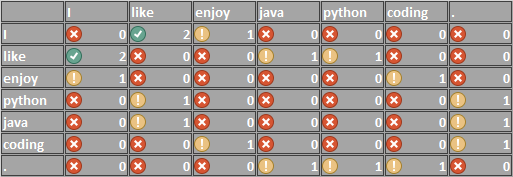

In [ ]:
cbr_data = data.copy()

In [ ]:
cbr_data.drop(remove, axis=1, inplace=True)
cbr_data.drop('Runtime', axis=1, inplace=True)

In [ ]:
cbr_data.head()

In [ ]:
def create_soup(data):
    # Creating a simple text for countvectorizer to work with
    att = data['Title'].lower()
    for i in data[1:]:
            att = att + ' ' + str(i)
            return att

In [ ]:
%%time
# Create the soup for count vectorizer
cbr_data['soup'] = cbr_data.apply(create_soup, axis=1)

In [ ]:
%%time
# Apply countvectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(cbr_data['soup'])

#### Finding Cosine Similarity

In [ ]:
%%time
cosine_sim2 = cosine_similarity(count_matrix)

In [ ]:
# The function will return top 10 movies related to given movie
def get_recommendations_new(title, data, o_data, cosine_sim=cosine_sim2):
    data = data.reset_index()
    indices = pd.Series(data.index, index=cbr_data['Title'])
    idx = indices[title]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    o_data.Genres = o_data.Genres.str.replace(',', '<br>')
    o_data.Directors = o_data.Directors.str.replace(',', '<br>')
    o_data.Country = o_data.Country.str.replace(',', '<br>')
    o_data.Language = o_data.Language.str.replace(',', '<br>')
    return o_data[[
        'Title', 'IMDb', 'Genres', 'Directors', 'Country', 'Language'
    ]].iloc[movie_indices]

In [ ]:
l = get_recommendations_new('The Avengers', cbr_data, orig_data.copy(), cosine_sim2)

In [ ]:
# Replacing the NA values by -1 for sorting
l.IMDb=l.IMDb.apply(replaceNAby1)
l.IMDb=l.IMDb.astype(float)

In [ ]:
# Plotting the dat using plotly
l.sort_values(by='IMDb',ascending=False,inplace=True)
colorscale = [[0, '#477BA8'], [.5, '#C9EEF2'], [1, '#D0F5F5']]
fig = ff.create_table(l, colorscale=colorscale, height_constant=70)

fig.show()

### Content Based Filtering: KNN

In [ ]:
cf_data = data.copy()
cf_data.head()

In [ ]:
# Get dummies for dummy columns
cf_data=pd.get_dummies(cf_data,columns=dummy)

In [ ]:
cf_data.drop(remove,
             inplace=True,
             axis=1)

In [ ]:
# Dropping title as we do not need it
cf_data.drop('Title', inplace=True, axis=1)

In [ ]:
# Label encode the directors column
cf_data.Directors=LabelEncoder().fit_transform(cf_data.Directors)

In [ ]:
# Apply the KNN with cosine metric
model_knn = NearestNeighbors(metric='cosine',
                             algorithm='auto',
                             n_neighbors=20,
                             n_jobs=-1)
model_knn.fit(cf_data)

In [ ]:
# Create a function to recommend top 10 movies
def recommend_movies(movie):
    movie_index=cf_data[orig_data.Title==movie].index
    distances, indices = model_knn.kneighbors(np.array(cf_data.iloc[movie_index]).reshape(
    1, -1),n_neighbors=10)
    s_data=orig_data.iloc[indices[0]][['Title','IMDb', 'Age', 'Directors', 'Genres']]
    s_data.IMDb=orig_data.IMDb.apply(replaceNAby1)
    s_data.IMDb=s_data.IMDb.astype(float)
    return s_data.sort_values(by='IMDb',ascending=False)

In [ ]:
recommend_movies('The Avengers')

In [ ]:
# We will be pickling he viriable for our WebApp 
with open('knn_model.pickle', 'wb') as f:
    pickle.dump(model_knn, f)

For WebApp please refer to the movie_recommendation_app.py